In [1]:
using CSV, DataFrames, Statistics, Clustering, Plots, Random, Gurobi, JuMP, DataStructures, StatsBase

In [94]:
data_prev = CSV.read("data/pred_Maria.csv",DataFrame)
data_opti = CSV.read("data/opti_Maria.csv",DataFrame)

data_logistic = CSV.read("data/opti_Maria.csv",DataFrame)
pred_logistic = CSV.read("data/pred_lr.csv",DataFrame)[:, "0"];
pred_logistic_week = Matrix(CSV.read("data/pred_lr_week.csv",DataFrame))
pred_logistic_sms = Matrix(CSV.read("data/pred_lr_sms.csv",DataFrame));

In [3]:
#number booked appointments
na = nrow(data_prev)
#number new appointments
nb = nrow(data_opti)
ntot = na + nb
#number doctors
nd = 15
#penalty added nurse
pen_nurse = 5
#previously_booked
s = data_prev.slot .+1 ;

### Model 1 : Only penalize double booking (day)

In [4]:
function optim_add_nurse(p)
model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
set_optimizer_attribute(model, "OutputFlag", 0)

@variable(model, x[1:ntot, 1:50], Bin)
@variable(model, t[1:50])

@objective(model, Min, sum(t)*pen_nurse)

@constraint(model, [j=1:50], t[j] >= sum(x[i,j]*p[i,j] for i=1:ntot) - nd) 
@constraint(model, [j=1:50], t[j] >= 0)

for i=1:na
    for j=1:50
        if s[i]==j
            @constraint(model, x[i,j] == 1)
        else
            @constraint(model, x[i,j] == 0)
        end
    end
end

for i=na+1:ntot
    for j=1:50
        if j in a[i-na,:]
        else
            @constraint(model, x[i,j] == 0)
        end
    end
end

@constraint(model, [i=1:ntot], sum(x[i,j] for j=1:50) == 1)
        

optimize!(model)
return objective_value(model), JuMP.value.(x)
end

optim_add_nurse (generic function with 1 method)

In [22]:
a = Matrix(data_opti[:,121:125]);

In [23]:
p_oracle = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_oracle[i,j] = 1 - data_prev.NoShow[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_oracle[i,j] = 1 - data_opti.NoShow[i-na]
    end
end

In [24]:
o, _ = optim_add_nurse(p_oracle)
o

Academic license - for non-commercial use only - expires 2022-08-18


930.0

In [25]:
p_random = rand(ntot, 50);
_, x_r = optim_add_nurse(p_random)
sum([max(sum(x_r[i,j]*p_oracle[i,j] for i=1:ntot) - nd, 0)*pen_nurse for j=1:50])

Academic license - for non-commercial use only - expires 2022-08-18


1020.0

In [26]:
p_no_idea = ones(ntot, 50) .- 0.5;
_, x_ni = optim_add_nurse(p_no_idea)
sum([max(sum(x_ni[i,j]*p_oracle[i,j] for i=1:ntot) - nd, 0)*pen_nurse for j=1:50])

Academic license - for non-commercial use only - expires 2022-08-18


1070.0

In [27]:
p_logistic = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i-na]
    end
end

In [28]:
_, x_log = optim_add_nurse(p_logistic)
sum([max(sum(x_log[i,j]*p_oracle[i,j] for i=1:ntot) - nd, 0)*pen_nurse for j=1:50])

Academic license - for non-commercial use only - expires 2022-08-18


985.0

### Model 2 : Only penalize double booking (week)

In [79]:
a = Matrix(data_opti[:, 111:120]) .+ 1;
p = rand(ntot, 50);

In [35]:
s_m = reshape(counts(s, 50), (10,5));

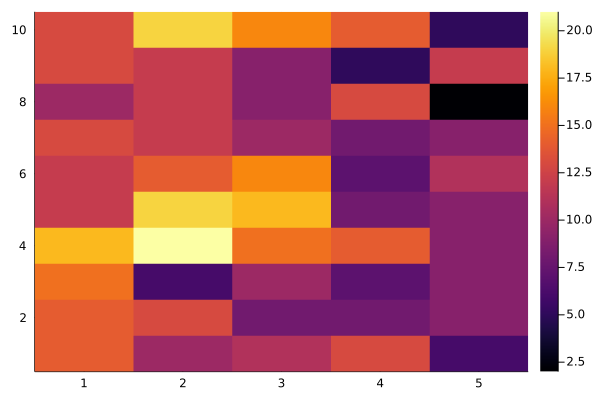

In [36]:
heatmap(s_m)

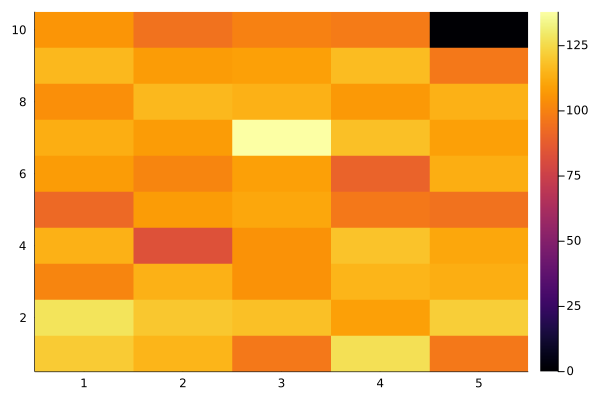

In [37]:
a_m = reshape(counts(a, 50), (10,5))
heatmap(a_m)

In [50]:
_, x = optim_add_nurse(p)

Academic license - for non-commercial use only - expires 2022-08-18


(1.9218298695022484, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [52]:
schedul = reshape(sum(x[i,:] for i=1:ntot), (10,5))

10×5 Matrix{Float64}:
 37.0  26.0  21.0  24.0  17.0
 32.0  27.0  17.0  12.0  13.0
 41.0  14.0  20.0  19.0  22.0
 32.0  21.0  22.0  20.0  20.0
 29.0  30.0  27.0  19.0  16.0
 29.0  23.0  25.0  14.0  20.0
 29.0  19.0  25.0  17.0  19.0
 24.0  28.0  18.0  25.0  20.0
 29.0  22.0  18.0  19.0  19.0
 25.0  28.0  20.0  19.0   5.0

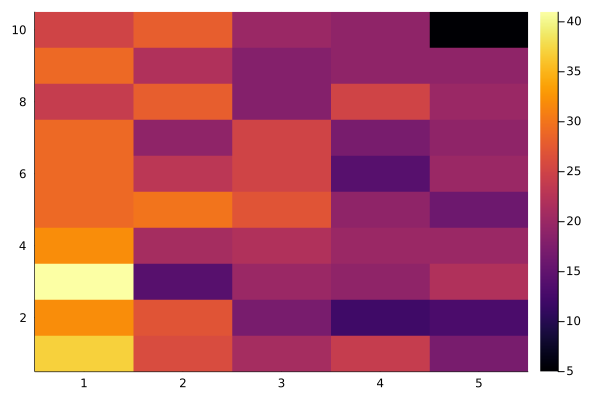

In [53]:
heatmap(schedul)

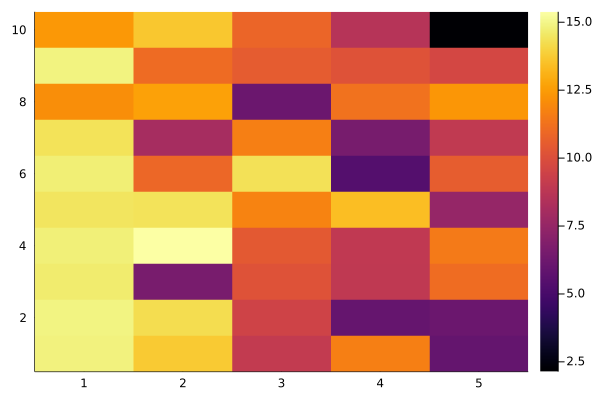

In [54]:
schedule_show = reshape([sum(x[i,j]*p[i,j] for i=1:ntot) for j=1:50], (10,5));
heatmap(schedule_show)

In [55]:
sum([max(sum(x[i,j]*(p[i,j]>0.5) for i=1:ntot) - nd, 0) for j=1:50])

8.0

##### Comparison with random

In [56]:
opti_random = [rand(1:50) for i=1:nb];

In [57]:
x_random = cat(s, opti_random, dims=1);

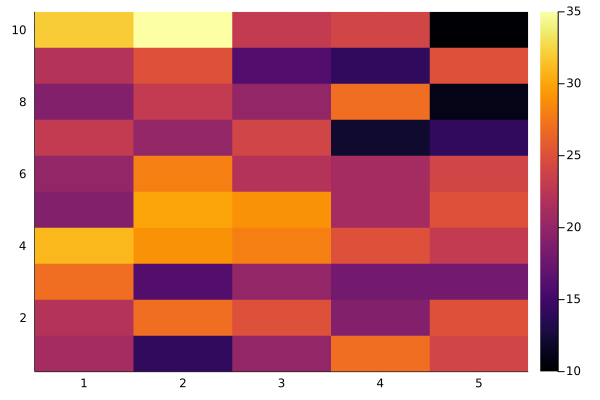

In [58]:
x_random_m = reshape(counts(x_random, 50), (10,5))
heatmap(x_random_m)

In [59]:
x_r = zeros(ntot, 50)
for i = 1:ntot
    for j = 1:50
        if x_random[i]==j
            x_r[i,j]=1
        end
    end
end

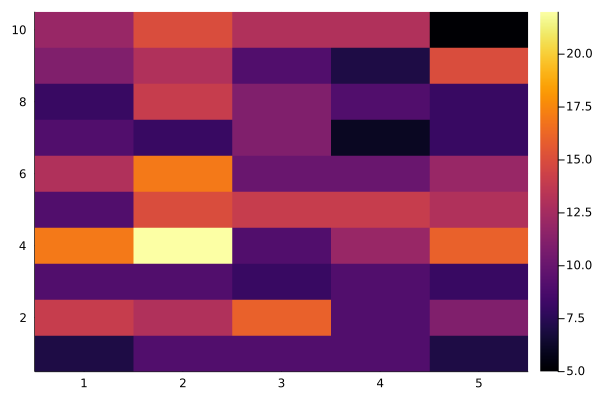

In [60]:
random_show = reshape([sum(x_r[i,j]*(p[i,j]>0.5) for i=1:ntot) for j=1:50], (10,5));
heatmap(random_show)

In [61]:
sum([max(sum(x_r[i,j]*(p[i,j]>0.5) for i=1:ntot) - nd, 0) for j=1:50])

13.0

##### Comparison with model logistic regression

In [84]:
p_logistic = zeros(ntot,50)
for i = 1:na
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i]
    end
end
for i = na+1:ntot
    for j=1:length(a[1,:])
        p_logistic[i,a[i-na,j]] = 1 - pred_logistic_week[5*(i-na-1) + j]
    end
end

In [85]:
_, x = optim_add_nurse(p_logistic)

Academic license - for non-commercial use only - expires 2022-08-18


(661.6213513165654, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 -0.0])

In [87]:
sum([max(sum(x[i,j]*(p_logistic[i,j]>0.5) for i=1:ntot) - nd, 0) for j=1:50])

366.0

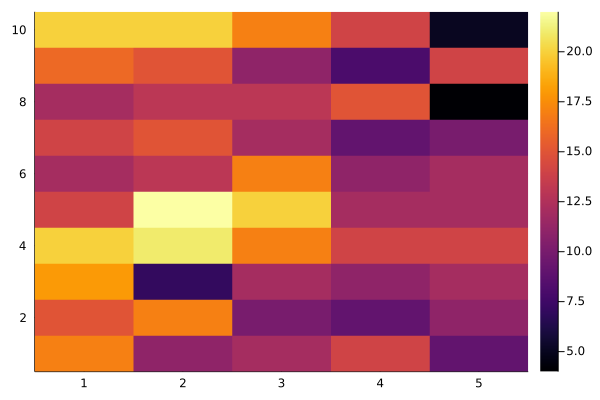

In [89]:
logistic_show = reshape([sum(x_r[i,j]*(p_logistic[i,j]>0.5) for i=1:ntot) for j=1:50], (10,5));
heatmap(logistic_show)

### Model 3 : SMS or not (day)

In [152]:
function optim_add_nurse_SMS(p_sms, p_nosms)
model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
set_optimizer_attribute(model, "OutputFlag", 0)

@variable(model, x[1:ntot, 1:50], Bin) #bin
@variable(model, t[1:50])
@variable(model, s[1:ntot, 1:50], Bin) #send SMS or not #bin
@variable(model, z[1:ntot, 1:50], Bin) # x & s (linearize) #binary

@objective(model, Min, sum(t)*pen_nurse + sum(z)*pen_sms)

@constraint(model, [j=1:50], t[j] >= sum(z[i,j]*p_sms[i,j] + (x[i,j]-z[i,j])*p_nosms[i,j]  for i=1:ntot) - nd) 
#@constraint(model, [j=1:50], t[j] >= sum(x[i,j]*s[i,j]*p_sms[i,j] + x[i,j]*(1-s[i,j])*p_nosms[i,j]  for i=1:ntot) - nd) 
@constraint(model, [j=1:50], t[j] >= 0)
    
@constraint(model, [i=1:ntot, j=1:50], z[i,j] <= (s[i,j] + x[i,j])/2)
@constraint(model, [i=1:ntot, j=1:50], z[i,j] >= s[i,j] + x[i,j] - 1)

for i=1:na
    for j=1:50
        if s[i]==j
            @constraint(model, x[i,j] == 1)
        else
            @constraint(model, x[i,j] == 0)
        end
    end
end

for i=na+1:ntot
    for j=1:50
        if j in a[i-na,:]
        else
            @constraint(model, x[i,j] == 0)
        end
    end
end

@constraint(model, [i=1:ntot], sum(x[i,j] for j=1:50) == 1)
        

optimize!(model)
return objective_value(model), JuMP.value.(x), JuMP.value.(s)
end

optim_add_nurse_SMS (generic function with 2 methods)

In [153]:
pen_nurse = 5
pen_sms = 1;

In [154]:
a = Matrix(data_opti[:,121:125])

p_sms, p_nosms = pred_logistic_sms[:,1], pred_logistic_sms[:,2]

p_sms_m = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_sms_m[i,j] = 1 - p_sms[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_sms_m[i,j] = 1 - p_sms[i-na]
    end
end

p_nosms_m = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_nosms_m[i,j] = 1 - p_nosms[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_nosms_m[i,j] = 1 - p_nosms[i-na]
    end
end

In [155]:
_, x, s = optim_add_nurse_SMS(p_sms_m, p_nosms_m)

Academic license - for non-commercial use only - expires 2022-08-18


LoadError: Result index of attribute MathOptInterface.ObjectiveValue(1) out of bounds. There are currently 0 solution(s) in the model.